In [1]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
from Bio.SeqUtils import gc_fraction

import config_readwrite as crw
import glob

import matplotlib.pyplot as plt
import numpy as np
import os, sys

import pandas as pd

from scipy import stats
import seaborn as sns

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


from plot_params import fonts
from statsmodels.stats.multitest import fdrcorrection

In [2]:
config, cfn = crw.read(os.path.join(os.path.dirname(os.getcwd()), "config.ini"))

CL = "hepg2"
section = "mpra"
FASTA = config[section]["fasta"]
MPRA = config[section][f"{CL}.clean.transformed"]
BUILD = "hg38"

section = "FIMO"
FIMO_PATH = "/wynton/home/ahituv/fongsl/EMF/US/data/fimo"#config[section]["path"]
FIMO_PRED = os.path.join(FIMO_PATH, "fimo.txt")#config[section]["pred"]
FIMO_MOTIF_MAX = os.path.join(FIMO_PATH, "fimo_motif.max_score.tsv.gz")
RE = "/wynton/home/ahituv/fongsl/EMF/US/results/fimo"#config[section]["path"]

FIMO_MOTIF_MAX_TABLE = os.path.join(FIMO_PATH, "fimo_motif.max_score_table.tsv.gz")
FIMO_MOTIF_MAX_PTABLE = os.path.join(FIMO_PATH, "fimo_motif.max_score_pvalue.table.tsv.gz")

# write
config[section]["max_score"]= FIMO_MOTIF_MAX
config[section]["max_score_table"]= FIMO_MOTIF_MAX_TABLE
config[section]["max_score_pval_table"]= FIMO_MOTIF_MAX_PTABLE

crw.write(config, cfn)


# set up fimo + jaspar run

In [3]:
if os.path.exists(RE) is False:
    os.mkdir(RE)

In [4]:
def runFimo(input_file, build, config):
    
    FIMO = os.path.join(os.environ["HOME"], "tools", "genome", "fimo.sh") # .py if you want to run in cmd line
    if os.path.exists(config) is False:
        empty_config = os.path.join(os.getcwd(), "config.ini")
        os.system(f"touch {empty_config}")
    
    cmd = " ".join([
        "qsub", 
        FIMO,
        input_file,
        f"-c {config}",
        f"-g {build}"
    ])
    print("running fimo", cmd)
    os.system(cmd)

In [5]:
def dfFilter(df, cl=None):
    
    
    
    df = df.loc[(~df["name"].str.contains("Synthetic"))&
                (~df["name"].str.contains("PosC"))&
                (~df["name"].str.contains("Neg"))
               ].reset_index(drop=True)  # (26803, 38)
    print("filter out synthetics, positive, negative controls", df.shape)
    
    if cl is not None:
        df = df.loc[df["name"].str.contains(cl.lower())].copy()  # keep only cl-nominated elements
        
        print("keep only", cl, "elements", df.shape, '\n\n')

    return df

## run

In [6]:
if os.path.exists(FIMO_PRED) is False:
    runFimo(FASTA, BUILD, cfn)

# GC content 

In [7]:
gc = {}
with open(FASTA) as handle:

    for values in SimpleFastaParser(handle):
        name, seq = values
        gc[name]=gc_fraction(seq)


In [8]:
# make a dataframe of GC values
gcdf = pd.DataFrame(gc.items())
gcdf.columns=["name", "gc"]  # rename columns

gcdf.head()

,name,gc
0,bj_k27ac_down_chr3:29837526-29837795,0.281481
1,bj_k27ac_down_chr3:29837260-29837529,0.281481
2,bj_k27ac_down_chr3:29837792-29838061,0.355556
3,bj_k27ac_down_chr3:29837392-29837661,0.303704
4,bj_k27ac_down_chr3:29837659-29837928,0.311111


<Axes: xlabel='gc', ylabel='Count'>

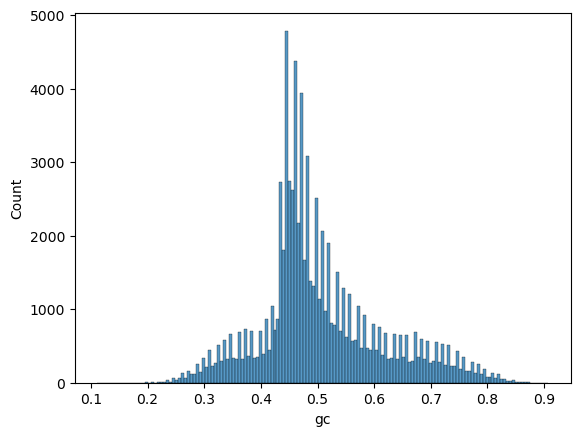

In [9]:
# histplot of % GC
sns.histplot(gcdf["gc"])

In [10]:
# summary stats of GC
gcdf["gc"].describe()

count    82427.000000
mean         0.505015
std          0.108679
min          0.111111
25%          0.444444
50%          0.481481
75%          0.559259
max          0.907407
Name: gc, dtype: float64

# MPRA ~ GC

In [11]:
df = pd.read_csv(MPRA, sep='\t',)
df = dfFilter(df, cl=CL)
df

filter out synthetics, positive, negative controls (58049, 34)
keep only hepg2 elements (4639, 34) 




,seq.id,name,label,ratio.med.ctrl,label.ctrl,ratio.1.ctrl,ratio.2.ctrl,ratio.3.ctrl,ratio.med.us,label.us,...,l2.ratio.2.us,l2.ratio.3.us,l2.ratio.med.ctrl,l2.ratio.mean.ctrl,l2.ratio.std.ctrl,l2.ratio.med.us,l2.ratio.mean.us,l2.ratio.std.us,delta.med,delta.mean
34353,seq.43942,hepg2_atac_down_chr10:100095190-100095459,Differential_ATAC,1.414455,1,1.516813,1.382924,1.343627,1.432937,1,...,0.770498,0.350692,0.467722,0.498299,0.091376,0.398108,0.506433,0.229913,-0.069613,0.008133
34354,seq.43944,hepg2_atac_down_chr10:100095322-100095591,Differential_ATAC,0.718156,0,0.741165,0.714932,0.698372,0.722043,0,...,-0.572358,-0.345943,-0.484122,-0.478063,0.043219,-0.500590,-0.472964,0.115708,-0.016468,0.005099
34355,seq.43945,hepg2_atac_down_chr10:100790811-100791080,Differential_ATAC,1.641549,1,1.761122,1.505293,1.658231,1.618850,1,...,0.418420,0.763570,0.729645,0.712061,0.114245,0.763570,0.682609,0.234439,0.033926,-0.029452
34356,seq.43946,hepg2_atac_down_chr10:100790878-100791147,Differential_ATAC,0.853855,0,0.868067,0.853947,0.839550,0.775888,0,...,-0.269714,-0.425189,-0.227782,-0.228072,0.024096,-0.408439,-0.367781,0.085340,-0.180657,-0.139709
34357,seq.43947,hepg2_atac_down_chr10:100790943-100791212,Differential_ATAC,0.768606,0,0.617148,0.801453,0.887216,0.730386,0,...,-0.510216,-0.362984,-0.319311,-0.396088,0.270145,-0.491090,-0.454763,0.080056,-0.171779,-0.058675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38987,seq.50125,hepg2_k27ac_up_chrX:75649063-75649332,Differential_H3K27ac,0.949372,0,0.917590,0.932830,0.997696,0.951423,0,...,-0.143612,-0.016044,-0.100314,-0.075907,0.063969,-0.058775,-0.072810,0.064932,0.041540,0.003096
38988,seq.50126,hepg2_k27ac_up_chrX:75649195-75649464,Differential_H3K27ac,1.476851,1,1.424745,1.493749,1.512058,1.507368,1,...,0.554228,0.582669,0.578937,0.562052,0.045329,0.582669,0.591612,0.042565,0.003731,0.029560
38989,seq.50127,hepg2_k27ac_up_chrX:75649330-75649599,Differential_H3K27ac,1.500579,1,1.461042,1.594081,1.446615,1.460385,1,...,0.493406,0.514389,0.546998,0.584134,0.077055,0.514389,0.545135,0.072192,-0.032609,-0.039000
38990,seq.50128,hepg2_k27ac_up_chrX:75649462-75649731,Differential_H3K27ac,1.151037,0,1.157226,1.147977,1.147909,1.173136,0,...,0.185299,0.238876,0.199093,0.202924,0.006709,0.238876,0.229984,0.040969,0.039783,0.027060


## Merge MPRA w GC data

In [12]:
TOP_BOTTOM = True
m = pd.merge(df, gcdf)

if TOP_BOTTOM is True:
    N = 50
    m = pd.concat([m.sort_values(by="delta.mean").iloc[:N].copy(),
                            m.sort_values(by="delta.mean").iloc[-N:].copy()])


In [13]:
m

,seq.id,name,label,ratio.med.ctrl,label.ctrl,ratio.1.ctrl,ratio.2.ctrl,ratio.3.ctrl,ratio.med.us,label.us,...,l2.ratio.3.us,l2.ratio.med.ctrl,l2.ratio.mean.ctrl,l2.ratio.std.ctrl,l2.ratio.med.us,l2.ratio.mean.us,l2.ratio.std.us,delta.med,delta.mean,gc
258,seq.44318,hepg2_atac_down_chr12:112295316-112295585,Differential_ATAC,1.053180,0,0.883950,1.180312,1.095277,0.687432,0,...,-0.340436,0.131295,0.064167,0.216516,-0.545176,-0.551240,0.213901,-0.676472,-0.615408,0.392593
2548,seq.47406,hepg2_atac_up_chr10:103715544-103715813,Differential_ATAC,0.923271,0,0.786864,1.081335,0.901613,0.617782,0,...,-0.444909,-0.149419,-0.127473,0.230100,-0.673729,-0.714134,0.291535,-0.524310,-0.586661,0.581481
1001,seq.45359,hepg2_atac_down_chr1:17502332-17502601,Differential_ATAC,0.798718,0,0.936293,0.708312,0.751547,0.566174,0,...,-0.682741,-0.412064,-0.334858,0.212101,-0.778934,-0.827588,0.174341,-0.366870,-0.492729,0.588889
2122,seq.46818,hepg2_atac_down_chr6:156617513-156617782,Differential_ATAC,0.909359,0,0.912400,0.922912,0.892766,0.652807,0,...,-0.655494,-0.132261,-0.137214,0.024337,-0.655494,-0.622565,0.176817,-0.523233,-0.485351,0.533333
1891,seq.46518,hepg2_atac_down_chr4:2361479-2361748,Differential_ATAC,0.770412,0,0.849456,0.608658,0.853121,0.551367,0,...,-0.975390,-0.235389,-0.393621,0.279462,-0.918411,-0.863949,0.146474,-0.683022,-0.470329,0.625926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4630,seq.50117,hepg2_k27ac_up_chr9:137454504-137454773,Differential_H3K27ac,0.895038,0,0.973975,0.996572,0.714565,1.206720,0,...,-0.005008,-0.038043,-0.175953,0.268034,0.207203,0.252402,0.282732,0.245247,0.428355,0.640741
4529,seq.49907,hepg2_k27ac_up_chr10:79066756-79067025,Differential_H3K27ac,0.974211,0,0.881764,1.161765,0.879104,1.320614,1,...,0.158093,-0.181535,-0.050371,0.230969,0.338806,0.386010,0.254819,0.520341,0.436380,0.566667
822,seq.45100,hepg2_atac_down_chr17:8314769-8315038,Differential_ATAC,0.938136,0,0.775841,0.979146,1.059421,1.354727,0,...,-0.079942,-0.030404,-0.104431,0.233687,0.233926,0.370523,0.532080,0.264330,0.474954,0.603704
791,seq.45048,hepg2_atac_down_chr17:74301262-74301531,Differential_ATAC,0.407101,-1,0.314601,0.467456,0.439248,0.583240,0,...,-0.583984,-1.186894,-1.317466,0.307220,-0.801698,-0.786717,0.195673,0.385196,0.530749,0.566667


### Missing MPRA data for some fasta sequences? 
- 23906 synthetic sequences are missing in intersection of fasta and MPRA dataframes. 
    - n= 11171/35077 synthetic sequences accounted for
- 100% covered:
    - DEG
    - ATAC
    - H3K27ac
    - Neg
    - pos
    - shuffle

In [14]:
# count of names in merge of MPRA + GC 
m.groupby(["label"])['name'].count()

label
Differential_ATAC       93
Differential_H3K27ac     7
Name: name, dtype: int64

In [15]:
# count of names in MPRA dataframe
df.groupby(["label"])['name'].count()

label
Differential_ATAC       4341
Differential_H3K27ac     298
Name: name, dtype: int64

### eval set difference, intersection

In [16]:
gc_ = set(gcdf["name"])
n = set(df["name"])

len(gc_.difference(n)), len(gc_.intersection(n))

(77788, 4639)

## Linear model

In [17]:
pipe = Pipeline([('scaler', StandardScaler()), ('reg', LinearRegression())])

X = np.vstack(m["gc"])
y = np.vstack(m["logFC"])

pipe.fit(X, y)

print(pipe.score(X, y))

reg = pipe.named_steps["reg"]

0.02982906029401844


## GC content is not associated with log2FC in activity
- r2 = 0.0056350045883429845, coeff = 0.02

In [18]:
reg.coef_

array([[0.06326829]])

# Fimo outputs

## get headers

In [19]:
# 
NAMES_FILE = os.path.join(FIMO_PATH, "motif_id.txt")
NAMES = list(pd.read_csv(NAMES_FILE, sep='\t'))

KEEP_COLS = [['motif_id',
             'sequence_name',
             'score',
             'p-value',
             'matched_sequence'
             ]]

## function to get max motif score per sequence

In [20]:
def getMaxMotifScore(df):
    
    # get max motif score per sequence. 
    # Ignore multiple motif matches in single sequence for now. 
    max_score = df.groupby(["motif_id", "sequence_name"])["score"].max().reset_index() 
    
    # add back p-value
    max_score_df = pd.merge(max_score, df[["sequence_name", "score", "p-value"]]) 
    
    return max_score_df

    """
    ### is cognate P-value getting reported for max score? Yes. 

        TEST_SEQ = "k562_atac_down_chr14:94681314-94681583"  # sequence with 2 entries for MA1143.1  
        print(m.loc[m["sequence_name"]==TEST_SEQ, ["score", "p-value"]])


        # max score df
              score   p-value
        1289  10.3018  0.000083


        # original df
        print(df.loc[df["sequence_name"] ==TEST_SEQ, ["score", "p-value"]])
                score   p-value
        1482  10.1716  0.000092
        1483  10.3018  0.000083

    """

In [21]:
if os.path.exists(FIMO_MOTIF_MAX) is False:
    handle_dict = {}  # dictionary to collect the motif info.

    for f in fs:
        handle = os.path.split(f)[1]  # get the file name

        if "MA" in handle:

            # open motif prediction file
            df = pd.read_csv(f, sep='\t', header=None, names=names)

            # get the max motif score for each sequences.
            # precludes weaker motif predictions per sequence (e.g. if a sequence has 2 predictions for 1 motif, only max gets chosen)
            max_df = getMaxMotifScore(df)
            handle_dict[handle] = max_df
            print(max_df.shape)

        df = pd.concat(handle_dict.values()).drop_duplicates()

        print(df.shape)

        df.to_csv(FIMO_MOTIF_MAX, sep='\t', index=False, compression="gzip")
        
        
elif os.path.exists(FIMO_MOTIF_MAX_TABLE) is False:
    """turn long form data into table"""
    df = pd.read_csv(FIMO_MOTIF_MAX, sep='\t')
    score_table = pd.pivot(df, index="sequence_name",
                           columns="motif_id", values="score")
    score_table.to_csv(FIMO_MOTIF_MAX_TABLE, sep='\t', index=True, header=True, compression="gzip")

else:
    """load max score table 81k x 1677 (single max tfbs score per element)"""
    score_table=pd.read_csv(FIMO_MOTIF_MAX_TABLE, sep='\t')

score_table=score_table.set_index("sequence_name")
score_table.head()

,MA0001.2,MA0002.2,MA0003.4,MA0005.2,MA0007.3,MA0009.2,MA0010.1,MA0011.1,MA0012.1,MA0013.1,...,MA1983.1,MA1984.1,MA1985.1,MA1986.1,MA2005.1,MA2006.1,MA2007.1,MA2008.1,MA2009.1,MA2010.1
sequence_name,,,,,,,,,,,,,,,,,,,,,
BJ_down-DEG-prom_ENSG00000258064_chr12:71672690-71672959:+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,12.8455,NaN,NaN,NaN,NaN,12.5102
BJ_down-DEG-prom_ENSG00000258064_chr12:71672935-71673204:+,NaN,NaN,NaN,NaN,13.4828,NaN,14.6757,NaN,NaN,12.1339,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BJ_down-DEG-prom_ENSG00000258064_chr12:71673180-71673449:+,NaN,NaN,NaN,NaN,NaN,NaN,14.6757,NaN,NaN,11.4094,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BJ_down-DEG-prom_ENSG00000258064_chr12:71673425-71673694:+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BJ_down-DEG-prom_ENSG00000258064_chr12:71673670-71673939:+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.5669,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## fimo wide-form

### motif scores

In [22]:
m

,seq.id,name,label,ratio.med.ctrl,label.ctrl,ratio.1.ctrl,ratio.2.ctrl,ratio.3.ctrl,ratio.med.us,label.us,...,l2.ratio.3.us,l2.ratio.med.ctrl,l2.ratio.mean.ctrl,l2.ratio.std.ctrl,l2.ratio.med.us,l2.ratio.mean.us,l2.ratio.std.us,delta.med,delta.mean,gc
258,seq.44318,hepg2_atac_down_chr12:112295316-112295585,Differential_ATAC,1.053180,0,0.883950,1.180312,1.095277,0.687432,0,...,-0.340436,0.131295,0.064167,0.216516,-0.545176,-0.551240,0.213901,-0.676472,-0.615408,0.392593
2548,seq.47406,hepg2_atac_up_chr10:103715544-103715813,Differential_ATAC,0.923271,0,0.786864,1.081335,0.901613,0.617782,0,...,-0.444909,-0.149419,-0.127473,0.230100,-0.673729,-0.714134,0.291535,-0.524310,-0.586661,0.581481
1001,seq.45359,hepg2_atac_down_chr1:17502332-17502601,Differential_ATAC,0.798718,0,0.936293,0.708312,0.751547,0.566174,0,...,-0.682741,-0.412064,-0.334858,0.212101,-0.778934,-0.827588,0.174341,-0.366870,-0.492729,0.588889
2122,seq.46818,hepg2_atac_down_chr6:156617513-156617782,Differential_ATAC,0.909359,0,0.912400,0.922912,0.892766,0.652807,0,...,-0.655494,-0.132261,-0.137214,0.024337,-0.655494,-0.622565,0.176817,-0.523233,-0.485351,0.533333
1891,seq.46518,hepg2_atac_down_chr4:2361479-2361748,Differential_ATAC,0.770412,0,0.849456,0.608658,0.853121,0.551367,0,...,-0.975390,-0.235389,-0.393621,0.279462,-0.918411,-0.863949,0.146474,-0.683022,-0.470329,0.625926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4630,seq.50117,hepg2_k27ac_up_chr9:137454504-137454773,Differential_H3K27ac,0.895038,0,0.973975,0.996572,0.714565,1.206720,0,...,-0.005008,-0.038043,-0.175953,0.268034,0.207203,0.252402,0.282732,0.245247,0.428355,0.640741
4529,seq.49907,hepg2_k27ac_up_chr10:79066756-79067025,Differential_H3K27ac,0.974211,0,0.881764,1.161765,0.879104,1.320614,1,...,0.158093,-0.181535,-0.050371,0.230969,0.338806,0.386010,0.254819,0.520341,0.436380,0.566667
822,seq.45100,hepg2_atac_down_chr17:8314769-8315038,Differential_ATAC,0.938136,0,0.775841,0.979146,1.059421,1.354727,0,...,-0.079942,-0.030404,-0.104431,0.233687,0.233926,0.370523,0.532080,0.264330,0.474954,0.603704
791,seq.45048,hepg2_atac_down_chr17:74301262-74301531,Differential_ATAC,0.407101,-1,0.314601,0.467456,0.439248,0.583240,0,...,-0.583984,-1.186894,-1.317466,0.307220,-0.801698,-0.786717,0.195673,0.385196,0.530749,0.566667


In [23]:
# reindex MPRA according to JASPAR
m.rename(columns={"name":"sequence_name"}, inplace=True)

m = m.set_index("sequence_name").reindex(score_table.index)

m

,seq.id,label,ratio.med.ctrl,label.ctrl,ratio.1.ctrl,ratio.2.ctrl,ratio.3.ctrl,ratio.med.us,label.us,ratio.1.us,...,l2.ratio.3.us,l2.ratio.med.ctrl,l2.ratio.mean.ctrl,l2.ratio.std.ctrl,l2.ratio.med.us,l2.ratio.mean.us,l2.ratio.std.us,delta.med,delta.mean,gc
sequence_name,,,,,,,,,,,,,,,,,,,,,
BJ_down-DEG-prom_ENSG00000258064_chr12:71672690-71672959:+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BJ_down-DEG-prom_ENSG00000258064_chr12:71672935-71673204:+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BJ_down-DEG-prom_ENSG00000258064_chr12:71673180-71673449:+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BJ_down-DEG-prom_ENSG00000258064_chr12:71673425-71673694:+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BJ_down-DEG-prom_ENSG00000258064_chr12:71673670-71673939:+,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
k562_k27ac_up_chrX:48918380-48918649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
k562_k27ac_up_chrX:48918512-48918781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
k562_k27ac_up_chrX:48918646-48918915,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# remove nas (sequences that didn't get tested for activity in MPRA
m = m.loc[~m["seq.id"].isna()]
m.shape

(100, 34)

In [26]:
# keep only scores w/ MPRA measurements
score_table = score_table.loc[score_table.index.isin(m.index)]

score_table.head()

,MA0001.2,MA0002.2,MA0003.4,MA0005.2,MA0007.3,MA0009.2,MA0010.1,MA0011.1,MA0012.1,MA0013.1,...,MA1983.1,MA1984.1,MA1985.1,MA1986.1,MA2005.1,MA2006.1,MA2007.1,MA2008.1,MA2009.1,MA2010.1
sequence_name,,,,,,,,,,,,,,,,,,,,,
hepg2_atac_down_chr10:29842028-29842297,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,11.4038,NaN,NaN,11.4082,NaN,NaN,NaN
hepg2_atac_down_chr10:75521218-75521487,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hepg2_atac_down_chr11:520980-521249,NaN,NaN,17.2358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,10.2846,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hepg2_atac_down_chr11:69825132-69825401,NaN,NaN,12.5691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hepg2_atac_down_chr11:75734843-75735112,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Feature selection
- keep only TF motifs that are in 

In [28]:
# how many MPRA elements are labeled as active in US or CTRL or response? 
m.loc[m["label.ctrl"]==1].shape, m.loc[m["label.us"]==1].shape, m.loc[m["response"]==True].shape

((17, 34), (27, 34), (6, 34))

In [32]:
syn = score_table.loc[score_table.index.str.contains("SYN")&
                      (~score_table.index.str.contains("shuf")) &
                      (~score_table.index.str.contains("Neg"))&
                      (~score_table.index.str.contains("PosC"))
                      
                      ]

other = score_table.loc[score_table.index.str.contains("Neg")|
                      (score_table.index.str.contains("shuf"))|
                      (score_table.index.str.contains("PosC"))
                      ]
gen = score_table.loc[(score_table.index.str.contains("chr")) &
                      (~score_table.index.str.contains("shuf")) &
                      (~score_table.index.str.contains("Neg"))&
                      (~score_table.index.str.contains("PosC"))&
                      (score_table.index.str.contains(CL))
                      ]
syn.shape, gen.shape, other.shape

((0, 1677), (100, 1677), (0, 1677))

In [33]:
def selectFeatures(df):
    PERCENT_ELEMENTS = 0.10

    keep_cols= []
    for col in list(df):
        if df.loc[df[col]>1].shape[0] >= df.shape[0]*PERCENT_ELEMENTS:
            keep_cols.append(col)
    print(len(keep_cols))
    
    return keep_cols

## compute correlation between TFBS motifs

In [42]:
CORR = os.path.join(RE, "all_TFBS_motif_corr.tsv")

if os.path.exists(CORR) is False:
    
    """write correlations to file, as this takes 4 minutes to run"""
    corrs = score_table.corr()
    corrs.to_csv(CORR, sep='\t')
else:
    corrs = pd.read_csv(CORR, sep='\t')
    
# remove na correlations    
corrs_nona = corrs.loc[~corrs[corrs.columns[0]].isna()]

In [27]:
out = os.path.join(RE, "all_TFBS_motif_corr.pdf")

if os.path.exists(out) is False:
    sns.clustermap(corrs_nona.fillna(0), cmap="bwr", center=0, 
              cbar_kws={"label":"pearson's r"})
                   
    plt.savefig(out, bbox_inches='tight')

some TFBS motifs with high internal correlation can be removed.... 

# genomics elements

## select TFBS motifs that occur in at least 10% of the dataframe. 

In [34]:
gene_feats = selectFeatures(gen)
gen[gene_feats].fillna(0)

360


,MA0002.2,MA0003.4,MA0014.3,MA0016.1,MA0017.2,MA0023.1,MA0039.4,MA0048.2,MA0062.3,MA0065.2,...,MA1967.1,MA1969.1,MA1972.1,MA1973.1,MA1976.1,MA1979.1,MA1980.1,MA1981.1,MA1982.1,MA1986.1
sequence_name,,,,,,,,,,,,,,,,,,,,,
hepg2_atac_down_chr10:29842028-29842297,0.0000,0.0000,0.0,0.00000,0.0000,0.0000,0.0000,12.5517,10.5214,0.0000,...,0.00000,0.00000,11.84270,0.00000,13.4944,0.0000,0.00000,10.87760,0.0,11.4038
hepg2_atac_down_chr10:75521218-75521487,0.0000,0.0000,0.0,0.00000,0.0000,0.0000,13.9455,13.5345,0.0000,0.0000,...,8.43103,0.00000,0.00000,0.00000,0.0000,0.0000,0.00000,17.67350,0.0,0.0000
hepg2_atac_down_chr11:520980-521249,0.0000,17.2358,0.0,0.00000,0.0000,0.0000,14.6455,0.0000,0.0000,0.0000,...,0.00000,0.00000,0.00000,8.01429,18.0000,17.0143,10.57580,8.46939,0.0,0.0000
hepg2_atac_down_chr11:69825132-69825401,0.0000,12.5691,0.0,0.00000,0.0000,12.4862,16.3364,0.0000,11.2286,0.0000,...,0.00000,0.00000,12.67420,13.30000,0.0000,0.0000,0.00000,0.00000,0.0,0.0000
hepg2_atac_down_chr11:75734843-75735112,0.0000,0.0000,0.0,0.00000,0.0000,0.0000,0.0000,0.0000,11.1286,0.0000,...,2.24138,0.00000,0.00000,0.00000,0.0000,0.0000,0.00000,13.73470,0.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
hepg2_k27ac_down_chr7:116953106-116953375,0.0000,15.3333,0.0,0.00000,0.0000,0.0000,0.0000,0.0000,0.0000,12.7297,...,0.00000,0.00000,0.00000,0.00000,11.4944,0.0000,0.00000,11.66330,0.0,0.0000
hepg2_k27ac_up_chr10:79066756-79067025,0.0000,0.0000,0.0,0.00000,11.3469,10.8257,17.2636,0.0000,0.0000,0.0000,...,4.51724,0.00000,13.05620,0.00000,10.7753,0.0000,0.00000,0.00000,0.0,0.0000
hepg2_k27ac_up_chr16:21186202-21186471,11.4483,0.0000,0.0,9.93258,12.9388,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.00000,7.27632,0.00000,0.00000,0.0000,10.4857,8.79798,0.00000,0.0,0.0000


In [35]:
out = os.path.join(RE, f"gen_TFBS_motif_corr.{CL}.pdf")

if os.path.exists(out) is False:
    sns.clustermap(gen[gene_feats].fillna(0))
    plt.savefig(out, bbox_inches='tight')

# Kmeans 

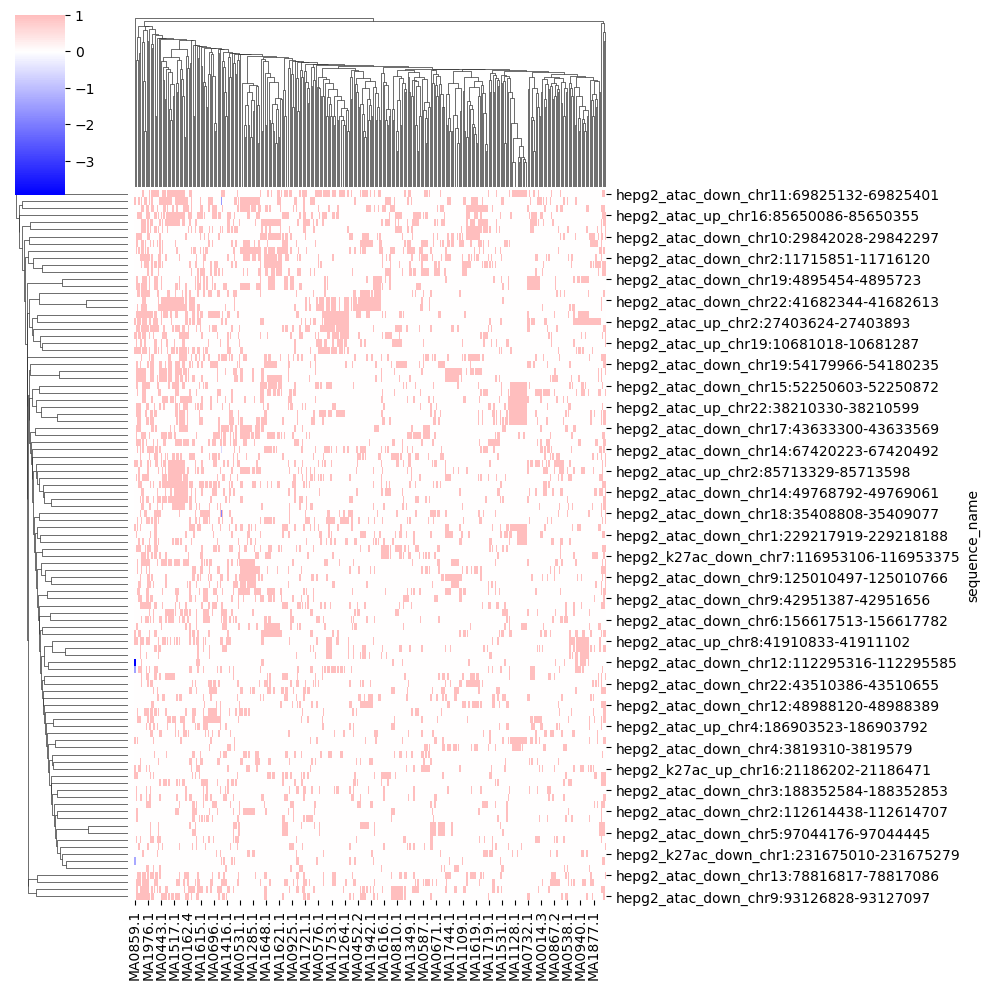

In [46]:
sns.clustermap(X, cmap="bwr", center=0)

# PCA

In [38]:
x_cols = gene_feats
data = gen
target = "label.ctrl"
BINARIZE = True

data_target = m.loc[m.index.isin(gen.index)].copy()  # get mpra data for sequences in genomic JASPAR dataframe
data_target.loc[data_target[target]==-1, target]=1

X = data[x_cols].copy().fillna(0)

# binarize element scores
if BINARIZE is True:
    for x in x_cols:
        X.loc[X[x] > 0, x] = 1

y = np.array(data_target[target])
print(X.shape, y.shape)

(100, 360) (100,)


In [ ]:
sns.clustermap(X, cmap="bwr", center=0)

In [39]:
from sklearn.decomposition import PCA

In [40]:
pipe = Pipeline([('scaler', StandardScaler()), ('pca', PCA(n_components=10))])

## do PCA on scaled data
X_= pipe.fit_transform(X, y)

pca = pipe.named_steps["pca"]

print(pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum()) 

[0.05690263 0.04490845 0.04060249 0.03629955 0.03232563 0.03049006
 0.02885409 0.02635677 0.02382624 0.02293183] 0.3434977429573089


/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/wynton/home/ahituv/fongsl/.conda/envs/mamba/lib/python3.9/site-packages/sklearn/utils/validation.py:767: FutureWarning:

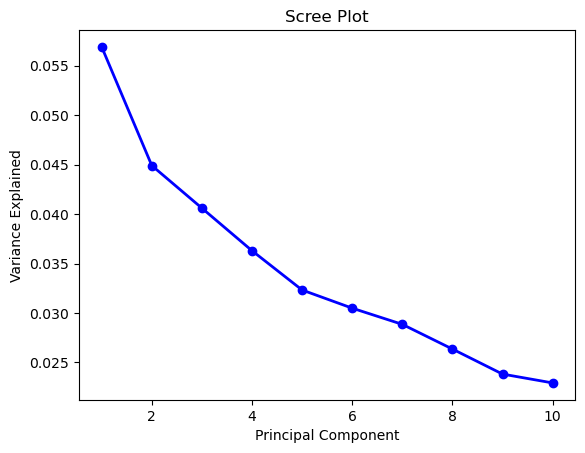

In [41]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

MA0002.2


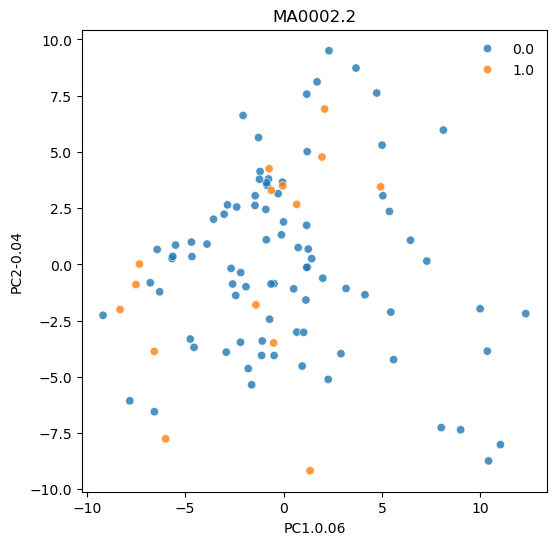

In [45]:
# make dataframe from result PCs
plot_=pd.DataFrame(X_)

## combine PCA and labels
for n, name in enumerate(x_cols):
    print(name)
    plot_.index = np.array(X[x_cols[n]])
    plot = plot_.reset_index()

    for i in np.arange(pca.n_components):
        if i!=pca.n_components-1:
            x, y = i,i+1
            hue="index"
            hue_order = None
            fig, ax= plt.subplots(figsize = (6,6))
            sns.scatterplot(x=x,y=y, data=plot, hue=hue, hue_order=hue_order, alpha=0.8, #palette=cmap,
                            #s=100
                           )
            ax.set(xlabel=f"PC{x+1}.{round(pca.explained_variance_ratio_[x], 2)}", 
                  ylabel=f"PC{y+1}-{round(pca.explained_variance_ratio_[y], 2)}", 
                  title=name)
            ax.legend(bbox_to_anchor =(1,1), frameon=False)
            break
    if n ==0:
        break

In [44]:
n

6

# logistic regression
label.ctrl ~ score_table JASPAR motifs (where 10% of the MPRA library N=5861 have motif)

In [ ]:
data_target.groupby([target])["seq.id"].count()

In [ ]:
# make pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('lr', LogisticRegression())])

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# fit the pipeline
pipe.fit(X_train, y_train)

print(pipe.score(X_test, y_test))

reg = pipe.named_steps["lr"]

y_train_pred = reg.predict(X_train)
y_pred = reg.predict(X_test)

# performance

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

            prediction        
               0       1                
             -----   -----  
          0 | TN   |  FP        
    actual   -----   -----   
          1 | FN   |  TP 

In [ ]:
confusion_matrix(y_train, y_train_pred)

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
prec
recall

In [ ]:
prec, recall, _ = precision_recall_curve(y_test, y_pred, )
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

### correlation of 100 random columns

In [ ]:
# randomly sample 100 
random_col = list(np.random.choice(data.columns, size=100) )

In [ ]:
data = score_table
c = data[random_col].corr()

cg = sns.clustermap(c.fillna(0), cmap='bwr',
                    figsize=(6, 6), 
                    center=0, 
                    cbar_kws={"label":"pearson r"})
cg.ax_row_dendrogram.set_visible(False)
cg.ax_col_dendrogram.set_visible(False)

In [ ]:
c.head()

In [ ]:
len(set(df["motif_id"]))

In [ ]:
df.head()